In [1]:
from datetime import datetime
from IPython.display import display

How does polars lazy execution work?
how does it minimize memory footprint and maximize CPU utilization?

**memory friendly** - streams data instead of loading to memory <br>
**cpu utilzation** - uses multithreading/processing to parallelize functions

for building queries or doing data transformations/joining, I imagine it keeps a record of the things relevant to a query (probably disctionaries) and performs transformations or calculations on the fly (additional processes)

**Dictionaries are easy to work with but not memory-efficient!** <br>

dictionary values can be stored anywhere in memory and accessing elements by keys can be slow.

**lists are memory efficient because you access elements by index instead of by keys!** and list elements are stored adjacent to each other in memory so going from one element to another is easier. 

I want to use Pew Research Survey Data to explore data engineering topics/methodologies.
specifically I wanted to showcase some columnar-based approaches to loading and analyzing datasets, raw pythonic ways to merge and correlate data and then the Polars (or other library) equivalents.

I think that by showing how the methodology can be reproduced without extra libraries, we can gain a deeper and more intutitive and ingrained understanding of why we use the tools we do, as opposed to just memorizing how to do things with said tools.

**Citation: Pew Research Center’s American Trends Panel**  <br>
**The opinions expressed herein, including any implications for policy, are those of the author and not of Pew Research Center.**

#### What is in a Pew Serearch Survery Dataset?

1. Survey results in the form of a csv
2. An excel workbook with they survey codes (values and what questions/answers they represent)
3. PDF of the questionairre
4. PDF of the survery methodology

I can see that we'll need to do some correlation or merging/lookup-type operations between item 1 and 2 (fun stuff)

#### Let's open the excel sheet and see what is in it:

In [2]:
from pathlib import Path
from openpyxl import load_workbook

In [3]:
path_to_workbook = Path(r'D:\VisualStudio\Python\public_projects\polars_research\datasets\W139_Dec23\ATP W139 Codebook.xlsx')

In [4]:
# establish good practices from the start!

if not path_to_workbook.exists():
    raise FileNotFoundError(f'{path_to_workbook} does not exist')

try:
    workbook = load_workbook(filename=path_to_workbook, data_only=True, read_only=True)
except Exception as e:
    print(e)

In [5]:
workbook.sheetnames

['Codebook']

In [6]:
active_sheet = workbook['Codebook']

for row in active_sheet.iter_rows():
    for cell in row:
        print(cell.coordinate)

A1


Something is off about this workbook (**Iterating through all rows but it only returns data from the first cell**).. <br>so to debug let's try to open it with pandas

In [7]:
import pandas as pd

In [8]:
try:
    codebook_df = pd.read_excel(path_to_workbook, sheet_name=None)
except Exception as e:
    print(e)
finally:
    print(codebook_df)

{'Codebook':                  Variable        Variable_Label               Values  \
0                    QKEY             Unique ID               101437   
1                    QKEY                   NaN          2.02301e+11   
2    INTERVIEW_START_W139  Interview start time  2023-11-27 19:50:47   
3    INTERVIEW_START_W139                   NaN  2023-12-03 23:30:24   
4      INTERVIEW_END_W139    Interview end time  2023-11-27 19:56:10   
..                    ...                   ...                  ...   
466           F_INC_TIER2                   NaN                    2   
467           F_INC_TIER2                   NaN                    3   
468           F_INC_TIER2                   NaN                   99   
469           WEIGHT_W139       Wave 139 weight           0.02553506   
470           WEIGHT_W139                   NaN             4.945435   

      Value_Labels  
0        Min. Val.  
1         Max. Val  
2        Min. Val.  
3         Max. Val  
4        Min. Val

Interesting, that worked... we could have a separate project to go over handling xlsx files with python.. for now, just to get the ball rolling we'll use pandas to load this lookup table

In [9]:
#codebook_df is a dictionary of dataframes. each key is a sheet for each sheet,
#there is a dataframe to represent the table at that sheet

for sheet, sheet_df in codebook_df.items():
    display(sheet_df)

,Variable,Variable_Label,Values,Value_Labels
0,QKEY,Unique ID,101437,Min. Val.
1,QKEY,NaN,2.02301e+11,Max. Val
2,INTERVIEW_START_W139,Interview start time,2023-11-27 19:50:47,Min. Val.
3,INTERVIEW_START_W139,NaN,2023-12-03 23:30:24,Max. Val
4,INTERVIEW_END_W139,Interview end time,2023-11-27 19:56:10,Min. Val.
...,...,...,...,...
466,F_INC_TIER2,NaN,2,Middle income
467,F_INC_TIER2,NaN,3,Upper income
468,F_INC_TIER2,NaN,99,Refused
469,WEIGHT_W139,Wave 139 weight,0.02553506,Min. Val.


#### What is this lookup table??

I think for this to make sense, we have to take a peek at the survey data csv file

In [10]:
atp_w139_survey_data = Path(r'D:\VisualStudio\Python\public_projects\polars_research\datasets\W139_Dec23\ATP W139.csv')

let's read the first couple of rows only... <br>
keep in mind we can read the filesize, but for the following reason, let's assume we don't know <br>
what the actual memory footprint would be of loading the entire dataset into memory (reading the entire file <br>
or loading it all into a pandas dataframe) <br>

1. when you load a table into a pandas dataframe, it all gets loaded into memory. <br> for small files this is okay, but for anything larger than a few GB, it could blow up your memory... <br> everything in a Pandas dataframe is a python object. each object contains some amount of metadata or builtin methods or other things that take up additional memory than just the raw data.


In [11]:
import csv
from pprint import pprint

In [12]:
if not atp_w139_survey_data.exists():
    raise FileNotFoundError(f'{datetime.now()} {atp_w139_survey_data} does not exist')

with open(atp_w139_survey_data, 'r', newline='', encoding='utf-8', errors='replace') as f:
    reader = csv.DictReader(f)

    first_row = next(reader)
    print(f'Number of columns: {len(list(first_row.keys()))}')
    print("="*50,end="+\n")
    pprint(first_row)

Number of columns: 96
==================================================+
{'BIDEN_FAVORISRPAL_W139': '',
 'COEX_W139': '2',
 'COLGIMP_W139': '3',
 'COLGJOB_W139': '5',
 'DEGRCOST_W139': '3',
 'DEVICE_TYPE_W139': '1',
 'DTREPPTY_W139': '1',
 'EDUCJOB_W139': '4',
 'FORM_W139': '2',
 'F_AGECAT': '4',
 'F_ATTENDPER': '2',
 'F_BIRTHPLACE': '1',
 'F_BORN': '1',
 'F_CDIVISION': '4',
 'F_CREGION': '2',
 'F_EDUCCAT': '2',
 'F_EDUCCAT2': '4',
 'F_GENDER': '2',
 'F_HISP': '2',
 'F_HISP_ORIGIN': '',
 'F_IDEO': '2',
 'F_INC_SDT1': '2',
 'F_INC_TIER2': '2',
 'F_INTFREQ': '2',
 'F_MARITAL': '3',
 'F_METRO': '2',
 'F_PARTYLN_FINAL': '',
 'F_PARTYSUMIDEO_FINAL': '1',
 'F_PARTYSUM_FINAL': '1',
 'F_PARTY_FINAL': '1',
 'F_RACECMB': '1',
 'F_RACETHNMOD': '1',
 'F_REG': '1',
 'F_RELIG': '1',
 'F_RELIGCAT1': '1',
 'F_USR_SELFID': '3',
 'F_VOLSUM': '2',
 'F_YEARSINUS_RECODE': '1',
 'INSTFAV_FED_W139': '4',
 'INSTFAV_LOC_W139': '2',
 'INSTFAV_STAT_W139': '3',
 'INSTFAV_a_W139': '',
 'INSTFAV_b_W139': '',
 'INS

Basically, each column name maps to a question (row) in the Codebook/lookup table, and each value corresponds to an answer. <br> Each row is a single interview from a single person.

If you look back at the Codebook dataframe, you'll see some NaN (Not a Number) values (nulls, None) that's because the table was formatted by a human... some cells were merged. so when pandas reads it, it (I guess) unmerges the cells and keeps the value only in the first... which I think is what happens when we unmerge a cell in excel as well..

so we have to fix the lookup table a bit before we start referencing it/correlating it to the survery data..

now.. let's go back to that Codebook dataframe and save it as it's own CSV. then read it back and fix the NaN cells.


In [13]:
codebook_dict = codebook_df['Codebook'].to_dict(orient='records')
#first 10 rows:
for i in range(10):
    pprint(codebook_dict[i])

{'Value_Labels': 'Min. Val.',
 'Values': '101437',
 'Variable': 'QKEY',
 'Variable_Label': 'Unique ID'}
{'Value_Labels': 'Max. Val',
 'Values': '2.02301e+11',
 'Variable': 'QKEY',
 'Variable_Label': nan}
{'Value_Labels': 'Min. Val.',
 'Values': '2023-11-27 19:50:47',
 'Variable': 'INTERVIEW_START_W139',
 'Variable_Label': 'Interview start time'}
{'Value_Labels': 'Max. Val',
 'Values': '2023-12-03 23:30:24',
 'Variable': 'INTERVIEW_START_W139',
 'Variable_Label': nan}
{'Value_Labels': 'Min. Val.',
 'Values': '2023-11-27 19:56:10',
 'Variable': 'INTERVIEW_END_W139',
 'Variable_Label': 'Interview end time'}
{'Value_Labels': 'Max. Val',
 'Values': '2023-12-03 23:36:00',
 'Variable': 'INTERVIEW_END_W139',
 'Variable_Label': nan}
{'Value_Labels': 'Laptop/PC',
 'Values': 1,
 'Variable': 'DEVICE_TYPE_W139',
 'Variable_Label': 'The device used in the latest access of the survey link'}
{'Value_Labels': 'Smartphone',
 'Values': 2,
 'Variable': 'DEVICE_TYPE_W139',
 'Variable_Label': nan}
{'Value_L

we want to replace all the nan values with the correct label that corresponds to variable

I tried fixing it by keeping a dict or strings to map each Variable to it's corresponding Variable_Label and then replacing nan values with a value from that map... I later learned this is called a 'fill forward' and for an ordered table like ours (ordered because we just read the excel sheet as someone made it, not modifying anything) we don't need anything more complex than a variable to hold the last non-nan value of the Value_Label column.

In [14]:
codebook_rows = [codebook_df['Codebook'].columns.tolist()] + codebook_df['Codebook'].values.tolist()
codebook_rows[0:2]

[['Variable', 'Variable_Label', 'Values', 'Value_Labels'],
 ['QKEY', 'Unique ID', '101437', 'Min. Val.']]

In [15]:
last_known_label = None

for row in codebook_dict:
    if not pd.isna(row['Variable_Label']):
        last_known_label = row.get('Variable_Label')
    else:
        row.update({'Variable_Label':last_known_label})

codebook_dict

[{'Variable': 'QKEY',
  'Variable_Label': 'Unique ID',
  'Values': '101437',
  'Value_Labels': 'Min. Val.'},
 {'Variable': 'QKEY',
  'Variable_Label': 'Unique ID',
  'Values': '2.02301e+11',
  'Value_Labels': 'Max. Val'},
 {'Variable': 'INTERVIEW_START_W139',
  'Variable_Label': 'Interview start time',
  'Values': '2023-11-27 19:50:47',
  'Value_Labels': 'Min. Val.'},
 {'Variable': 'INTERVIEW_START_W139',
  'Variable_Label': 'Interview start time',
  'Values': '2023-12-03 23:30:24',
  'Value_Labels': 'Max. Val'},
 {'Variable': 'INTERVIEW_END_W139',
  'Variable_Label': 'Interview end time',
  'Values': '2023-11-27 19:56:10',
  'Value_Labels': 'Min. Val.'},
 {'Variable': 'INTERVIEW_END_W139',
  'Variable_Label': 'Interview end time',
  'Values': '2023-12-03 23:36:00',
  'Value_Labels': 'Max. Val'},
 {'Variable': 'DEVICE_TYPE_W139',
  'Variable_Label': 'The device used in the latest access of the survey link',
  'Values': 1,
  'Value_Labels': 'Laptop/PC'},
 {'Variable': 'DEVICE_TYPE_W139'

In [16]:
def fill_forward(rows: list[dict],col_to_ffill: str, output_path: Path):
    last_known_label = None

    for row in rows:
        col_to_ffill_value = row.get(col_to_ffill,'NA')
        if col_to_ffill_value == 'NA':
            raise KeyError(col_to_ffill)
        if not pd.isna(col_to_ffill_value):
            last_known_label = row.get(col_to_ffill)
        else:
            row.update({col_to_ffill:last_known_label})
        
    with open(output_path, 'w', newline='', encoding='utf-8') as f:
        headers = []
        for row in rows:
            for k in row.keys():
                if k not in headers:
                    headers.append(k)
    
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
    
        writer.writerows(codebook_dict)

In [17]:
excluded_v_labels = ['Unique ID','Interview start time','Interview end time','Wave 139 weight']

In [18]:
from collections import defaultdict

In [19]:
def build_lookup(rows: list[dict], primary_header: str):
    survey_questions = {}
    
    for row in rows:
        variable_label = row.get(primary_header, None)
        
        if not variable_label:
            raise KeyError(primary_header)
        
        if variable_label not in survey_questions and variable_label not in excluded_v_labels:
            codes = {
                "variable":row.get('Variable'),
                "responses":{
                    str(row.get('Values')):row.get('Value_Labels')
                }
            }
            survey_questions[variable_label] = codes
        elif variable_label in survey_questions and variable_label not in excluded_v_labels:
            if (val := str(row.get('Values'))) not in survey_questions[variable_label]['responses']:
                survey_questions[variable_label]['responses'][val] = row.get('Value_Labels')
    return survey_questions

In [20]:
question_lookup = build_lookup(codebook_dict,'Variable_Label')

In [21]:
for q in question_lookup.keys():
    print(q)

The device used in the latest access of the survey link
 Language of interview
Wave 139 form assignment
Flag to identify Republicans, Republican leaners and non-leaners.
Flag to identify registered voters
All in all, are you satisfied or dissatisfied with the way things are going in this country today?
Do you approve or disapprove of the way Joe Biden is handling his job as president?
Do you [approve/disapprove] of the way Joe Biden is handling his job as president…
The Republican Party // Do you have a favorable or unfavorable opinion of each of the following?
The Democratic Party // Do you have a favorable or unfavorable opinion of each of the following?
Congress // Do you have a favorable or unfavorable opinion of each of the following?
The federal government in Washington // Do you have a favorable or unfavorable opinion of each of the following?
Your STATE government // Do you have a favorable or unfavorable opinion of each of the following?
Your LOCAL government // Do you have a 

In [22]:
def get_responses(question: str):
    response_rows = []
    with open(atp_w139_survey_data, 'r', newline='', encoding='utf-8', errors='replace') as f:
        reader = csv.DictReader(f)
    
        #question_keys = list(question_lookup.keys())
    
        for row in reader:
            response = row.get(question_lookup[question].get('variable'))
            res_row = {"Question":question,"Response":question_lookup[question].get('responses').get(response)}
            response_rows.append(res_row)
    return pd.DataFrame(response_rows)

In [23]:
res_df = get_responses('Congress // Do you have a favorable or unfavorable opinion of each of the following?')

In [24]:
import plotly.express as px

In [43]:
def visualize_response(df, title: str):
    response_counts = df['Response'].value_counts().reset_index()
    response_counts.columns = ['Response', 'Count']
    
    fig = px.pie(response_counts,
    names='Response',      # what labels each slice
    values='Count',        # size of each slice
    title=title,
    width=600,
    height=600)
    
    #fig.update_traces(textposition='outside')
    fig.update_layout(
        margin=dict(t=100),
        title_font_size=10,
        height=600,
        width=600
    )
    
    fig.show()

In [26]:
questions_iter = iter(question_lookup.keys())

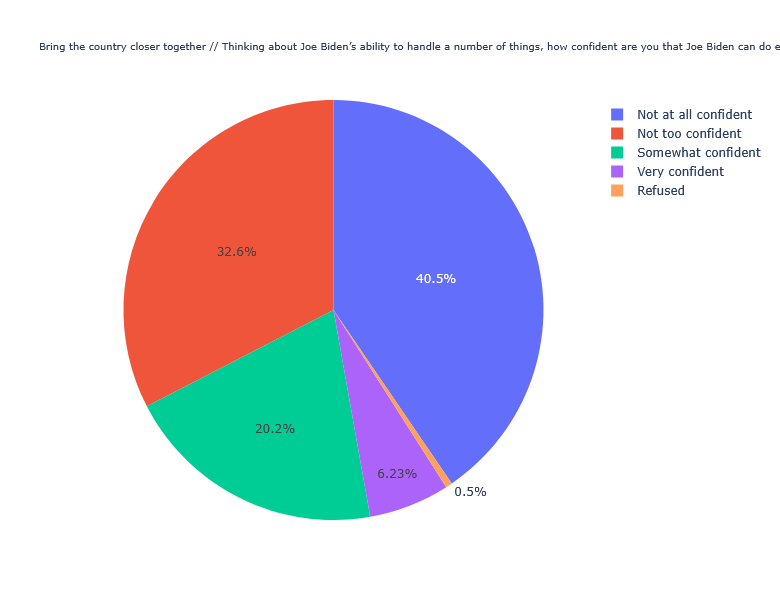

In [50]:
collect_question = next(questions_iter)
visualize_response(get_responses(collect_question), collect_question)